<a href="https://colab.research.google.com/github/mohd-faizy/12_Fake_News_Detection_with_Machine_Learning/blob/main/FakeNewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 
<strong> 
    <h1 align='center'>Fake News Detection with Machine Learning</h1> 
</strong>

---

## Cloning the Repository

In [1]:
!git clone https://github.com/mohd-faizy/12_Fake_News_Detection_with_Machine_Learning.git

Cloning into '12_Fake_News_Detection_with_Machine_Learning'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [2]:
import os

os.chdir('/content/12_Fake_News_Detection_with_Machine_Learning/data')
cwd = os.getcwd()
print('Curent working directory is ', cwd)

Curent working directory is  /content/12_Fake_News_Detection_with_Machine_Learning/data


In [3]:
ls

Fake.csv  True.csv


## IMPORT LIBRARIES AND DATASETS

In [4]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy # spaCy is an open-source software library for advanced natural language processing
!pip install WordCloud
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

Requirement already up-to-date: nbformat in /usr/local/lib/python3.7/dist-packages (5.1.3)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


- Setting the style of the notebook to be **monokai theme**  
- this line of code is important to ensure that we are able to see the $x$ and $y$ axes clearly
- If you don't run this code line, you will notice that the `xlabel` and `ylabel` on any plot is black on black and it will be hard to see them. 


In [5]:
!pip install jupyterthemes

     |████████████████████████████████| 7.0MB 10.5MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 9.5MB 166kB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 430kB 37.7MB/s 
ERROR: google-colab 1.0.0 has requirement notebook~=5.3.0; python_version >= "3.0", but you'll have notebook 6.4.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: notebook 5.3.1
    Uninstalling notebook-5.3.1:
      Successfully uninstalled notebook-5.3.1


In [6]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 


In [7]:
# load the data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

MINI CHALLENGE #1: 
- Indicate how many data samples do we have per class (i.e.: Fake and True)
- List how many Null element are present and the memory usage for each dataframe

## PERFORM EXPLORATORY DATA ANALYSIS

In [8]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 1
df_true.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [9]:
df_fake['isfake'] = 0
df_fake.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [10]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [11]:
df.drop(columns = ['date'], inplace = True)

In [12]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [13]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

## PERFORM DATA CLEANING

In [14]:
# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [16]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [17]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [18]:
# Show original news
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [19]:
# Show cleaned up news after removing stopwords
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [20]:
df

,title,text,subject,isfake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal..."


In [21]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


In [22]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [23]:
len(list_of_words)

9277072

In [24]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108705

In [25]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [26]:
df

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


In [27]:
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

MINI CHALLENGE #2:
- Perform sanity check on the prepocessing stage by visualizing at least 3 sample news 




## VISUALIZE CLEANED UP DATASET

In [28]:
df

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


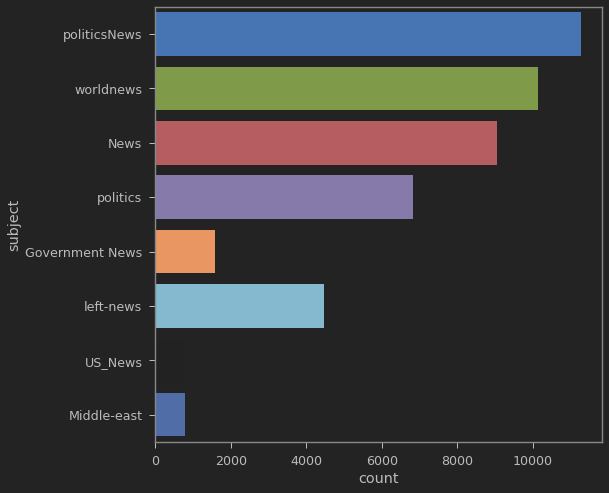

In [29]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df)
plt.show()

MINI CHALLENGE #3: 
- Plot the count plot for fake vs. true news

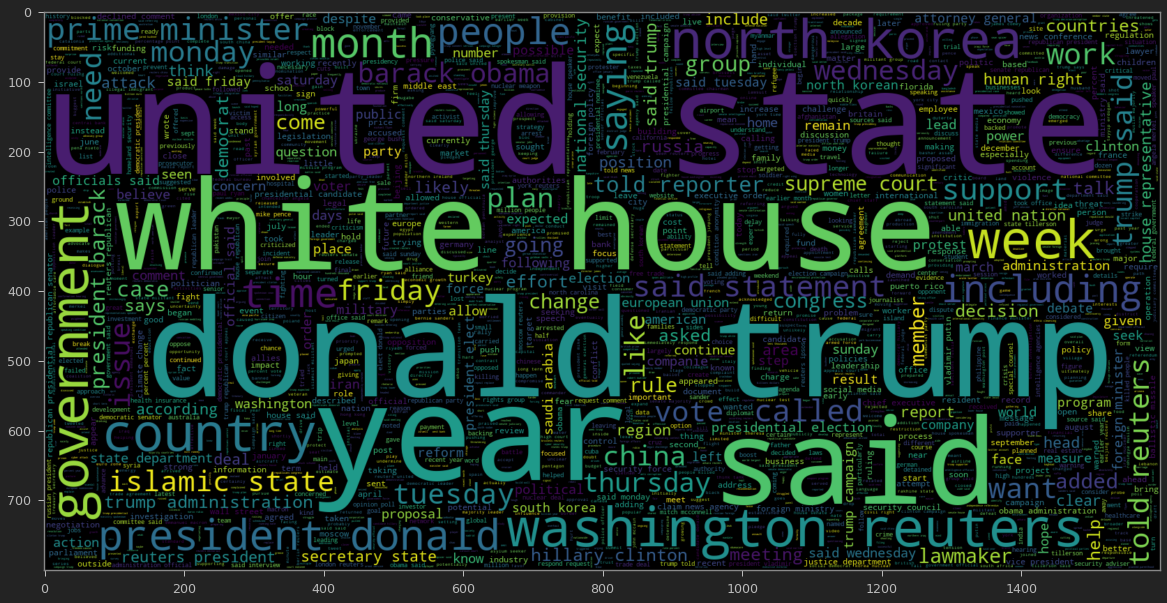

In [30]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

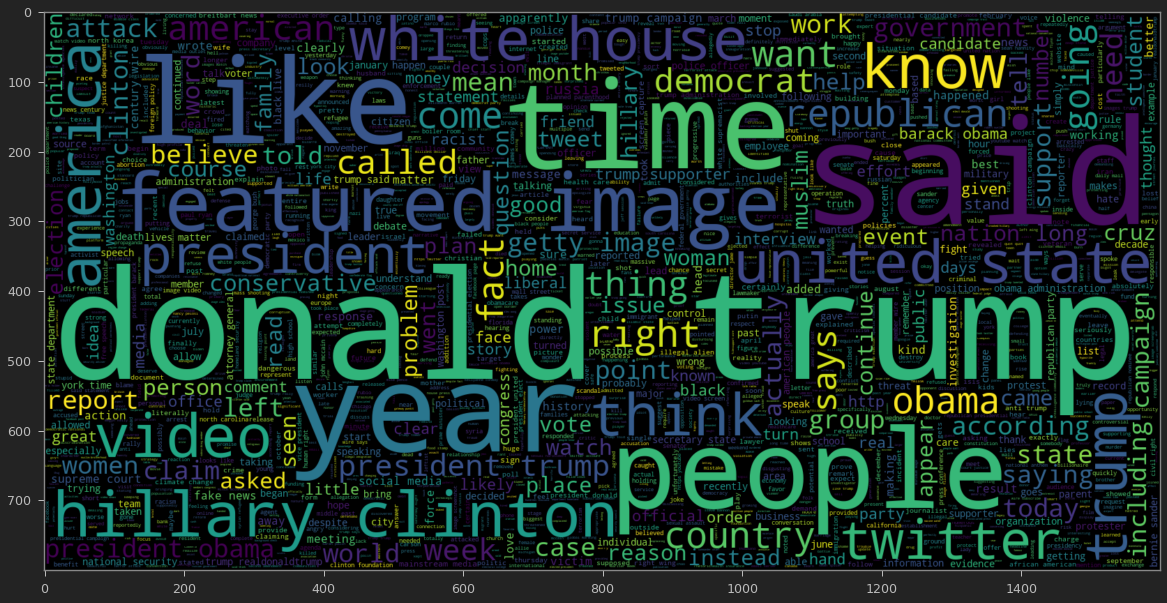

In [31]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [32]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4406


In [33]:
# visualize the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

## PREPARE THE DATA BY PERFORMING TOKENIZATION AND PADDING

In [34]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [35]:
from nltk import word_tokenize

In [36]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [37]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [38]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [39]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [  375  1882  1067   488  1336  1689  1648 20660  1848     8   937   394
   650  1067  2638   488   474   125   153  1336  1648    14   431  1689
 20660   371     2    81  1854  4506   375   386  3693  1232    60   662
  1789  1527 11683   472]
The padded encoding for document 2  is :  [   27  2330    44   131   109   490   289    46   131   109     3   219
 10219   261    29   117   109   209  1912   984    22 10139  1471  3138
    51    49    35   632  4671   413  3520 11793     7 49638  1496  2461
   790   742    27  1922]


## BUILD AND TRAIN THE MODEL 

In [40]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         13914240  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 14,210,433
Trainable params: 14,210,433
Non-trainable params: 0
_________________________________________________________________


In [41]:
total_words

108705

In [42]:
y_train = np.asarray(y_train)

In [43]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 117s 168ms/step - loss: 0.1177 - acc: 0.9394 - val_loss: 0.0040 - val_acc: 0.9989
Epoch 2/2
506/506 [==============================] - 84s 165ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0090 - val_acc: 0.9969


MINI CHALLENGE #4:
- Change the embedding output dimension and print out the model summary
- How many trainable parameters are there? 


## ASSESS TRAINED MODEL PERFORMANCE


In [44]:
# make prediction
pred = model.predict(padded_test)

In [45]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [46]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9965478841870824


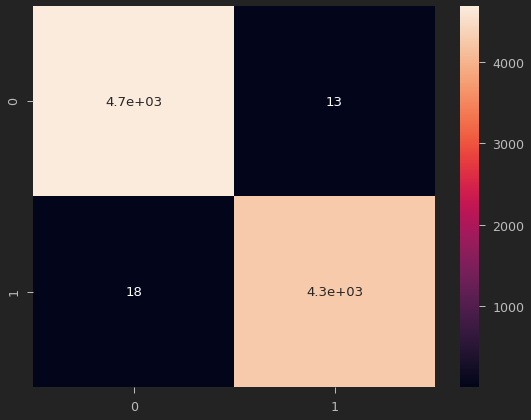

In [47]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (9, 7))
sns.heatmap(cm, annot = True)

In [48]:
# category dict
category = { 0: 'Fake News', 1 : "Real News"}

MINI CHALLENGE #1

In [49]:
# data containing real news
df_true
# data containing fake news
df_fake
# dataframe information
df_true.info()
# dataframe information
df_fake.info()
# check for null values
df_true.isnull().sum()
# check for null values
df_fake.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   isfake   21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   isfake   23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


title      0
text       0
subject    0
date       0
isfake     0
dtype: int64

MINI CHALLENGE #2:
- Perform sanity check on the prepocessing stage by visualizing at least 3 sample news 



In [50]:
df['original'][5]
df['clean_joined'][5]

'white house congress prepare talks spending immigration west palm beach washington reuters white house said friday kick talks week republican democratic congressional leaders immigration policy government spending issues need wrapped early year expected flurry legislative activity comes republicans democrats begin stage midterm congressional elections november president donald trump republican party eager maintain control congress democrats look openings wrest seats away senate house representatives wednesday trump budget chief mick mulvaney legislative affairs director marc short meet senate majority leader mitch mcconnell house speaker paul ryan republicans democratic counterparts senator chuck schumer representative nancy pelosi white house said followed weekend strategy sessions trump mcconnell ryan camp david presidential retreat maryland according white house senate returns work house congress passed short term government funding week taking christmas break needs come agreement 

MINI CHALLENGE #3: 
- Plot the count plot for fake vs. real news

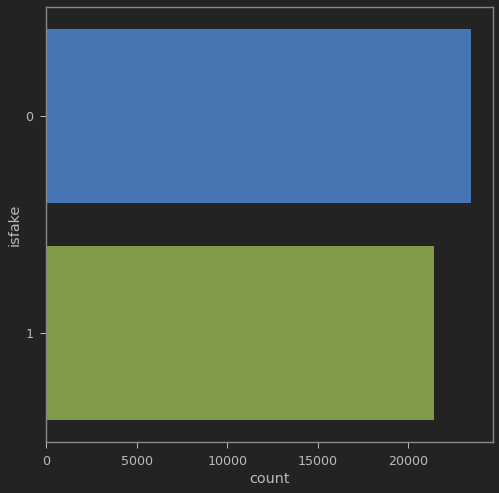

In [51]:
# plot the number of samples per each class
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

MINI CHALLENGE #4:
- Change the embedding output dimension and print out the model summary
- How many trainable parameters are there? 

In [52]:
# Change the embedding size to 240 for example and print out the summary 